### Utilisation de Google Colab

Si vous utilisez Google Colab, suivez les instructions ci-dessous.

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 8: Transformers

Introduction aux transformers:
- Révolution dans le monde du NLP (Vaswani, 2017), maintenant les majeurs architectures de NLP sont toutes basées sur les transformers (BERT, GPT). Ex. Generative Pre-trained Transformer (GPT) et Bidirectional Encoder Representations from Transformers (BERT). ChatGPT basé sur GPT.
- Maintenant, les transformers sont aussi utilisés dans d'autres domaines du deep learning grâce à leur grande flexibilité et polyvalence. Vision par ordinateur: ViT, Swin, DETR, etc., Point Clouds: ..., Audio: ...
- Intéressant que le transformer de 2017 est encore utilisé! Seulement quelques petites modifications
- Une sorte d'architecture universelle qui peut traiter tout type de données
- Présentent une affinité pour le prétraining en raison de leur meilleur scaling avec la quantité de données et la taille du modèle (scaling vision transformer et Scaling laws for neural language models)

Transformers:
- Les transformers sont basés sur le principle d'attention
- Modèle ensemble -> ensemble de vecteurs (ensemble dans le sens mathématique)
- Réutilise des concepts intéressants: Connexion résiduelle (flot du gradient), LayerNorm, MLP
- Liens avec le message passing / algorithm


In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import torch
import torch.random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Partie 1: Scaled Dot-Product Attention
- Au coeur des transformers se trouve le principle d'attention
- Focus sur certaines parties de l'information, et moins sur d'autres, somme ponderée selon l'attention
- Dans le cas des transformers, on utilise le "Scaled Dot-Product Attention" de Attention Is All You Need" (Vaswani, 2017)
- Principle de requête sur une base de données, on fait une requête, et on reçois une réponse
- On fait une requête $q$ selon des clés $k$, et on reçoit un valeur $v$
- Mais ici $q, k, v$ sont des vecteurs, et $v$ est une somme pondérée de plusieurs valeurs de la "base de données"
- Plus formellement, on a $D = \{(k_1, v_1), \ldots (k_m, v_m)\}$, un ensemble de clés $k_i$ et leur valeur $v_i$ associée, requête $q$.
- L'affinité entre $q$ et les $k_i$ est calculée par une fonction $\alpha(q, k_i)$, la réponse est une somme pondérée des $v_i$ selon $\alpha(\cdot)$
$$Attention(q, D) = \sum_{i=1}^{m}{\alpha(q, k_i)}$$
- On normalise avec une softmax
$$\alpha(q, k_i) = \frac{\exp(\alpha(q, k_i))}{\sum_j\exp(\alpha(q, k_j))}$$
- Pour Vaswani, on utilise le scale dot-product attention
$$\alpha(q, k_i) = \frac{q^Tk_i}{\sqrt{d}} = \frac{q \cdot k_i }{\sqrt{d}}$$
- $d$ est la dimension des vecteurs
- Au final, avec la softmax
$$\alpha(q, k_i) = \frac{\exp\left(q \cdot k_i / \sqrt{d}\right)}{\sum_j\exp\left(q \cdot k_i / \sqrt{d}\right)}$$

Dans la cellule suivante, remplisser la fonction suivante pour appliquer l'attention sur les tenseurs $q$, $k$ et $v$.

In [59]:
def simple_attention(q, k, v):
    """
    Attention simple
    q est un tenseur de dimension (1, d)
    k est un tenseur de dimension (n, d)
    v est un tenseur de dimension (n, d)
    d est la dimension des vecteurs, n le nombre de clés et de valeurs
    La sortie devrait être de dimension (1, d)
    """
    # TODO
    d = q.size(-1)
    alpha = F.softmax(q @ k.T / np.sqrt(d), dim=1)
    return alpha @ v
    
q = F.normalize(torch.tensor([[3.0, 3.0]]), dim=1)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -1], [0, 2]]), dim=1)
expected = torch.tensor([[0.2185, 0.4563]])

output = simple_attention(q, k, v)

print(f'simple_attention(q, k, v) =\t{output}')
print(f'valeur attendue =\t\t{expected}')

simple_attention(q, k, v) =	tensor([[0.2185, 0.4563]])
valeur attendue =		tensor([[0.2185, 0.4563]])


### Visualisation de l'attention
- Le produit scalaire a une interprétation utile, $q\cdot k_i = \|q\|\|k_i\|\cos(\theta)$, il s'agit donc d'une mesure de comment les vecteurs sont alligés


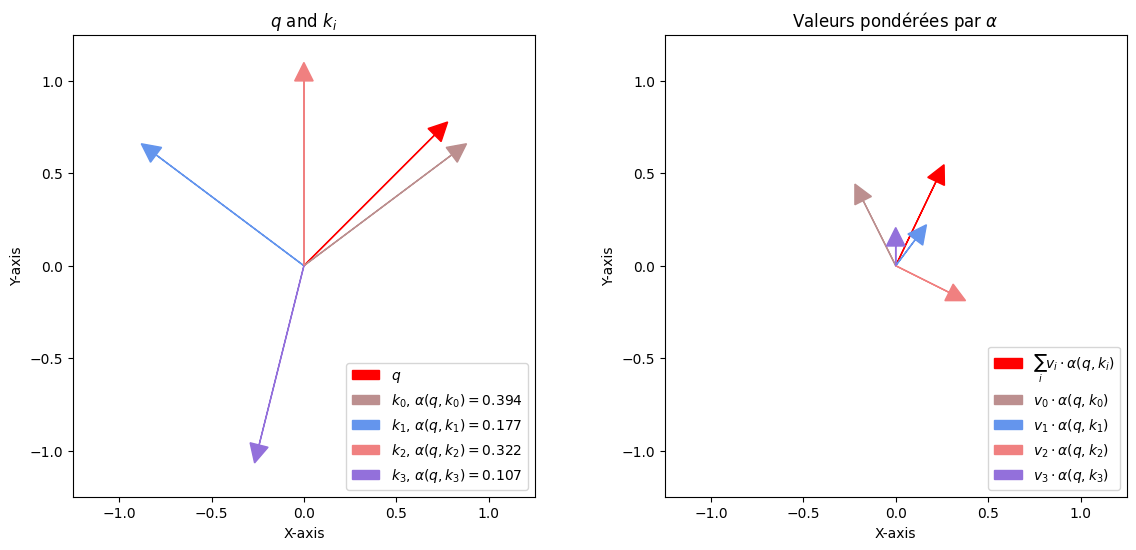

In [81]:
def show_attention(q, k, v):
    # TODO
    d = q.size(-1)
    alpha = F.softmax(q @ k.T / np.sqrt(d), dim=1)
    
    figs, axes = plt.subplots(ncols=2, figsize=(14, 6))
    ax = axes[0]
    ax.arrow(0, 0, q[0][0], q[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label='$q$')

    colors = ['rosybrown', 'cornflowerblue', 'lightcoral', 'mediumpurple']
    for i, k_i in enumerate(k):
        ax.arrow(0, 0, k_i[0], k_i[1], head_width=0.1, head_length=0.1, label=f'$k_{i}$, $\\alpha(q, k_{i}) = {alpha[0][i]:.3f}$', fc=colors[i], ec=colors[i])

    ax.set_xlim(-1.25, 1.25)
    ax.set_ylim(-1.25, 1.25)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('$q$ and $k_i$')
    ax.legend(loc='lower right')
    ax.set_aspect('equal', adjustable='box')
    
    ax = axes[1]
    ax.arrow(0, 0, output[0][0], output[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label='$\sum_i v_{i} \cdot \\alpha(q, k_{i})$')

    for i, v_i in enumerate(v):
        v_i = v_i * alpha[0, i]
        ax.arrow(0, 0, v_i[0], v_i[1], head_width=0.1, head_length=0.1, label=f'$v_{i} \cdot \\alpha(q, k_{i})$', fc=colors[i], ec=colors[i])

    ax.set_xlim(-1.25, 1.25)
    ax.set_ylim(-1.25, 1.25)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(r'Valeurs pondérées par $\alpha$')
    ax.legend(loc='lower right')
    ax.set_aspect('equal', adjustable='box')

    plt.show()
    
show_attention(q, k, v)

#### Questions
- Quel clé est la plus alignée avec $q$?
- Que ce passe-t'il avec les valeurs de $\alpha(\cdot)$ lorsque vous changer les $k_i$?
- Quel est l'impact sur la valeur retournée par l'attention?

### Le "Scaled" dans Scaled Dot-Product Attention
- Le facteur de $\frac{1}{\sqrt{d}}$ peut sembler inutile, pourtant il est central au bon fonctionnement de l'attention
- Si on fait l'hypothèse que $q_i$ et $k_i$ suivent une distribution normale $\mathcal{N}(0, 1)$, le produit entre $q$ et $k$ aura une variance de $d$.
- Il faut donc diviser par $\sqrt{d}$ afin d'obtenir une variance de $1$.

In [110]:
torch.manual_seed(1337)
num_tokens = 32
dimension = 256

q = torch.randn(num_tokens, dimension)
k = torch.randn(num_tokens, dimension)

attention = q @ k.T
scaled_attention = attention * dimension ** -0.5

print(f'Variance sans scaling: {attention.var()}')
print(f'Variance avec scaling: {scaled_attention.var()}')

Variance sans scaling: 259.6633605957031
Variance avec scaling: 1.0143100023269653


Sans scaling
- Sans scaling, la softmax va converger vers un vecteur one-hot.
- Ceci à pour effet de ne seulement aggréger de l'informatique que d'une seule valeur, limitant ainsi les performances du transformer.
- Le scaling permet une meilleure initialisation, et facilite l'optimisation du transformer

In [134]:
low_variance = torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)
high_variance = torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) * np.sqrt(256), dim=-1)

print(f'Softmax avec faible variance:\n\t{[round(x.item(), 5) for x in low_variance]}')
print(f'Softmax avec haute variance:\n\t{[round(x.item(), 5) for x in high_variance]}')

Softmax avec faible variance:
	[0.1925, 0.14261, 0.23512, 0.14261, 0.28717]
Softmax avec haute variance:
	[0.00159, 1e-05, 0.0391, 1e-05, 0.95928]


### Plusieurs queries
- Implémenter pour de l'attention avec plusieurs requêtes $q_i$
- On veut comparer chaque requête $q_i$ avec chaque clé $k_i$, on va le faire grâce à la multiplication de tenseurs


In [135]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Attention sur batch
    q est un tenseur de dimension (b, n, d)
    k est un tenseur de dimension (b, n, d)
    v est un tenseur de dimension (b, n, d)
    b est la taille de la mini-batch, d est la dimension des vecteurs, n le nombre de clés et de valeurs
    La sortie devrait être de dimension (b, n, d)
    """
    # TODO
    temp = query.bmm(key.transpose(-2, -1))  # or query @ key.transpose(1, 2)
    if mask is not None:
        temp[:, mask.logical_not()] = -torch.inf
    scale = query.size(-1) ** 0.5
    softmax = F.softmax(temp / scale, dim=-1)
    return softmax.bmm(value)

q = F.normalize(torch.tensor([[3.0, 3.0], [-1, 3.2], [0.2, -0.4], [0, -1]]), dim=1).unsqueeze(0)
k = F.normalize(torch.tensor([[2.0, 1.5], [-4, 3], [0, 3], [-1, -4]]), dim=1).unsqueeze(0)
v = F.normalize(torch.tensor([[-1.0, 2], [3, 4], [2, -3], [0, 2]]), dim=1).unsqueeze(0)
expected = torch.tensor([[[0.1089, 0.3322], [0.2860, 0.2639], [0.0600, 0.6791], [0.0986, 0.7087]]])

output = scaled_dot_product_attention(q, k, v)

print(f'scaled_dot_product_attention(q, k, v) =\n{output}')
print(f'valeur attendue =\n{expected}')

scaled_dot_product_attention(q, k, v) =
tensor([[[0.1089, 0.3322],
         [0.2860, 0.2639],
         [0.0600, 0.6791],
         [0.0986, 0.7087]]])
valeur attendue =
tensor([[[0.1089, 0.3322],
         [0.2860, 0.2639],
         [0.0600, 0.6791],
         [0.0986, 0.7087]]])


#### Questions
- Quelle est la taille du tenseur lorsque l'on multiple $q$ et $v$? Est-ce problématique pour le temps de calculs et la mémoire utilisée si $n$ augmente?
- Que se passe-t'il si on change l'ordre des queries?
- Que se passe-t'il si on change l'ordre des clés et des valeurs?
- Est-ce l'invariance à l'ordre des entrées est problématique? Quant est-t'il si l'ordre des valeurs est importante? comme l'ordre des mots dans une phrase

### Champ réceptif
- CNN vs Transformer

### Attention comme du passage de messages
- Graphe
- Q, K, aggregate V
- Graphe ont pas de positions -> fonction set de vecteurs vers set de vecteurs , doit encoder la position

### Self-attention vs cross-attention

## Partie 2: Multi-Head Attention
- Plusieurs têtes d'attention
- Plusieurs cannaux de communication séparés entre les noeuds

## Partie 3: TransformerEncoderLayer
- Multi-head self-attention
- Add and norm
- FF par token (attention = communication, FF est le token qui "pense")
- Connexion residuelle / skip (flot du gradient car l'addition distribue le grad egalement à chaque branche, aide à être deep, apprendre un delta)
- Prenorm vs postnorm

### BatchNorm vs LayerNorm
- LayerNorm ne demande pas de moyenne exponentielle, pas de difference entre train et test

In [58]:
torch.manual_seed(42)
batch_size = 32
dimension = 100
x = torch.randn(batch_size, dimension)
net = nn.Sequential(nn.Linear(100, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 100))
x = net(x)

# BatchNorm (normalement utiliserait une moyenne exponentielle)
xmean_batch = x.mean(0, keepdim=True)
xvar_batch = x.var(0, keepdim=True)
x_batch = (x - xmean_batch) / torch.sqrt(xvar_batch + 1e-12)
print('BatchNorm')
print(f'Par batch:\n\tmean: {x_batch[:, 0].mean()}\n\tvar: {x_batch[:, 0].var()}')
print(f'Par layer:\n\tmean: {x_batch[0, :].mean()}\n\tvar: {x_batch[0, :].var()}')

# LayerNorm
xmean_layer = x.mean(-1, keepdim=True)
xvar_layer = x.var(-1, keepdim=True)
x_layer = (x - xmean_layer) / torch.sqrt(xvar_layer + 1e-12)
print('LayerNorm')
print(f'Par batch:\n\tmean: {x_layer[:, 0].mean()}\n\tvar: {x_layer[:, 0].var()}')
print(f'Par layer:\n\tmean: {x_layer[0, :].mean()}\n\tvar: {x_layer[0, :].var()}')

BatchNorm
Par batch:
	mean: -1.4901161193847656e-08
	var: 1.0
Par layer:
	mean: 0.026868706569075584
	var: 1.249971628189087
LayerNorm
Par batch:
	mean: 1.2997647523880005
	var: 0.41209426522254944
Par layer:
	mean: 2.38418573772492e-09
	var: 1.0


## Partie 4: TransformerEncoder
- Plusieurs couches de TransformerEncoderLayer

## Partie 5: Entraînement

## Partie 6: Vision Transformer
- Utilise PyTorch car plus efficace
- https://towardsdatascience.com/a-demonstration-of-using-vision-transformers-in-pytorch-mnist-handwritten-digit-recognition-407eafbc15b0